## Setup

### Download SPQ from GitHub

In [1]:
!git clone -q https://github.com/ketakopter/spq.git
%cd -q spq

In [2]:
pip install .

Processing /content/spq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for spq: filename=spq-0.1.0-py3-none-any.whl size=13407 sha256=52d0761f5046c542d99a62f7f9d258a98db4696bcfdb6e639ec3ddadd32b4d38
  Stored in directory: /tmp/pip-ephem-wheel-cache-819d6cds/wheels/c0/98/d6/3bb39041b87d23f58d81c67f16f5258185ee7666ad87a08c1f
Successfully built spq


### Other modules

In [3]:
import numpy as np
import matplotlib.pyplot as plt

## Load SPQ with a custom file

The modules provided in the `spq.spq` package load the definitions from a json file. We can use the `spq.spq.environ` module to load them from the file specified in the `SPQFILE` environment variable.

In the examples directory we have a json file ready to be used:

In [4]:
import json
with open("examples/pq-roman.json") as fp:
  roman_units = json.load(fp)

In [5]:
roman_units['physical_quantities']

[{'name': 'Dist',
  'main_unit': 'pes',
  'conversions': [{'from': 'pes', 'to': 'digitus', 'factor': 16.0},
   {'from': 'pes', 'to': 'palmus', 'factor': 4.0},
   {'from': 'passus', 'to': 'pes', 'factor': 5.0},
   {'from': 'stadium', 'to': 'pes', 'factor': 625.0}]},
 {'name': 'Vol',
  'main_unit': 'congius',
  'conversions': [{'from': 'congius', 'to': 'quartarius', 'factor': 24.0},
   {'from': 'amphora', 'to': 'congius', 'factor': 8.0}]}]

The syntax of the json file is pretty self-explanatory, but you can see in the sections below what to expect from unit conversions.

We can set the `SPQFILE` environment variable to load the physical quantities from there.

In [6]:
import os
os.environ["SPQFILE"] = "examples/pq-roman.json"

And now the `spq.spq.environ` module loads the physical quantities into its namespace.

In [7]:
from spq.spq.environ import Dist, Vol

In [8]:
print(Dist._units, Vol._units)

['pes', 'digitus', 'palmus', 'passus', 'stadium'] ['congius', 'quartarius', 'amphora']


In [9]:
a = Dist.frompes(1)
print(a.digitus)
print(a.palmus)
print(a.pes)
print(a.passus)
print(a.stadium)

16.0
4.0
1.0
0.2
0.0016


In [10]:
print(Dist.fromstadium([1, 15]))

[625.0 9375.0]


In [11]:
print(Vol.fromamphora([1, 10]).congius)

[ 8. 80.]


In [12]:
print(Vol.fromamphora(1).quartarius)

192.0


## Create physical quantities at runtime

The `spq.base` package provides the functionalities to create physical quantities in a variety of ways. Most of the utilities are available in the `spq.base.pq` (for physical quantities) module, whereas `spq.base.gr` provides functionalities related to graphs.

### Load from external file

We can load into variables physical quantities from a json file. The quantities are loaded into a list. Thus, one "needs" to know what quantities are defined if they want to directly assing them to objects; the order is the same as in the json file.

In [13]:
from spq.base.pq import createPqsFromJsonFile

Dist, Vol = createPqsFromJsonFile("examples/pq-roman.json")

OK, now the quantities are the same as above...

In [14]:
print(Dist._units)

['pes', 'digitus', 'palmus', 'passus', 'stadium']


### Create a physical quantity from a dict

We can create a physical quantity if we specify the conversions between units, the main unit, and the name of the physical quantity in a dictionary. Basically, mimicking the structure of the json example.

Note that we don't need to specify *all* conversions. If everything is connected, it will work.

In [15]:
astro_dict = {
    'name': 'AstroDist',
    'main_unit': 'm',
    'conversions': [{'from': 'km',
                     'to': 'm',
                     'factor': 1.0e3},
                    {'from': 'au',
                     'to': 'km',
                     'factor': 149.5e6},
                    {'from': 'ly',
                     'to': 'au',
                     'factor': 63241.0},
                    {'from': 'pc',
                     'to': 'ly',
                     'factor': 3.26156}
    ]
}

In [16]:
from spq.base.pq import createPqFromDict

AstroDist = createPqFromDict(astro_dict)

In [17]:
AstroDist.fromly(1).m

9454529500000000.0

In [18]:
AstroDist.fromkm(np.linspace(1.5e8, 1.5e9, 2)).au

array([ 1.00334448, 10.03344482])

The conversions specified in a dict are simple linear scalings, although an offset can be specified too. Each conversion is a dictionary with keys `from`, `to`, `factor` and optionally `origin`.

In the examples above it is clear how a simple linear conversion is specified. For example, to convert from _km_ to _m_, one has to multiply by a factor of 1000, thus the conversion is:

```
{'from'  : 'km',
 'to'    : 'm',
 'factor': 1000.0 }
```

A typical example where an offset is needed is the temperature.

The conversion from Celsius to Fahrenheit degrees is given by `degC = 5/9*(degF − 32)` or conversely `degF = 9/5*degC + 32`. The Kelvin is `K = degC + 273.15`, and the Rankine `degR = degF + 459.67`.

In [19]:
temp_dict = {
    'name': 'Temp',
    'main_unit': 'K',
    'conversions': [
                    {
                    "from": "degC",
                    "to": "degF",
                    "factor": 1.8,
                    "origin": 32.0
                },
                {
                    "from": "degC",
                    "to": "K",
                    "factor": 1.0,
                    "origin": 273.15
                },
                {
                    "from": "degF",
                    "to": "degR",
                    "factor": 1.0,
                    "origin": 459.67
                }
    ]
}

In [20]:
Temp = createPqFromDict(temp_dict)

In [21]:
print(Temp.fromdegC(0).K)
print(Temp.fromdegC(0).degF)
print(Temp.fromdegC(0).degR)

273.15
32.0
491.67


In [22]:
print(Temp.fromdegR(0).K)

-5.684341886080802e-14


### Create a physical quantity with a list of conversions

We can create a physical quantity from a list of conversions, with each item in the list being a tuple of the form `(from, to, factor, origin)` (the last one is optional and defaults to 0).

Let's create lists based on the SI prefix conversion factors.

In [23]:
si_prefixes = {
  'Y': 1e24,
  'Z': 1e21,
  'E': 1e18,
  'P': 1e15,
  'T': 1e12,
  'G': 1e9,
  'M': 1e6,
  'k': 1e3,
  'h': 1e2,
  'da': 1e1,
  'd': 1e-1,
  'c': 1e-2,
  'm': 1e-3,
  'μ': 1e-6,
  'n': 1e-9,
  'p': 1e-12,
  'f': 1e-15,
  'a': 1e-18,
  'z': 1e-21,
  'y': 1e-24
}

In [24]:
length_units = [(k+'m', 'm', v) for k,v in si_prefixes.items()]
length_units

[('Ym', 'm', 1e+24),
 ('Zm', 'm', 1e+21),
 ('Em', 'm', 1e+18),
 ('Pm', 'm', 1000000000000000.0),
 ('Tm', 'm', 1000000000000.0),
 ('Gm', 'm', 1000000000.0),
 ('Mm', 'm', 1000000.0),
 ('km', 'm', 1000.0),
 ('hm', 'm', 100.0),
 ('dam', 'm', 10.0),
 ('dm', 'm', 0.1),
 ('cm', 'm', 0.01),
 ('mm', 'm', 0.001),
 ('μm', 'm', 1e-06),
 ('nm', 'm', 1e-09),
 ('pm', 'm', 1e-12),
 ('fm', 'm', 1e-15),
 ('am', 'm', 1e-18),
 ('zm', 'm', 1e-21),
 ('ym', 'm', 1e-24)]

In [25]:
mass_units = [(k+'g', 'g', v, 0.0) for k,v in si_prefixes.items()] # The fourth item in the tuple is for example's sake.
mass_units

[('Yg', 'g', 1e+24, 0.0),
 ('Zg', 'g', 1e+21, 0.0),
 ('Eg', 'g', 1e+18, 0.0),
 ('Pg', 'g', 1000000000000000.0, 0.0),
 ('Tg', 'g', 1000000000000.0, 0.0),
 ('Gg', 'g', 1000000000.0, 0.0),
 ('Mg', 'g', 1000000.0, 0.0),
 ('kg', 'g', 1000.0, 0.0),
 ('hg', 'g', 100.0, 0.0),
 ('dag', 'g', 10.0, 0.0),
 ('dg', 'g', 0.1, 0.0),
 ('cg', 'g', 0.01, 0.0),
 ('mg', 'g', 0.001, 0.0),
 ('μg', 'g', 1e-06, 0.0),
 ('ng', 'g', 1e-09, 0.0),
 ('pg', 'g', 1e-12, 0.0),
 ('fg', 'g', 1e-15, 0.0),
 ('ag', 'g', 1e-18, 0.0),
 ('zg', 'g', 1e-21, 0.0),
 ('yg', 'g', 1e-24, 0.0)]

Once we have a list of conversions, we need to create a graph out of it, which connects all units and contains all the conversion factors. The `spq.base.gr` module provides a function for that. The input list has only the one-direction conversion factors; the created graph contains the two-way linear conversions.

In [26]:
from spq.base.gr import graphOfLinearScaling

length_graph = graphOfLinearScaling(length_units)
mass_graph   = graphOfLinearScaling(mass_units)

A physical quantity is created with a graph (as explained above, containing all the units and their conversions linked), and the main unit.

In [27]:
from spq.base.pq import createPq

Length = createPq(length_graph, 'm')
Mass   = createPq(mass_graph, 'kg')

Note that even if in the list of the mass units all related to `g`, the quantity can be initialized with a different main unit (in this case `kg`) and it will work properly.

In [28]:
print(Length.frommm(1).μm)

1000.0


In [29]:
print(Mass.fromg(1))
print(Mass.fromg(1).kg)
print(Mass(1).kg)
print(Mass.frommg(1).μg)

0.001
0.001
1.0
1000.0


### Create a physical quantity from a graph

The ultimate way of defining a physical quantity is with a graph containing the relationships between the units.

Such a graph needs to contain units at the nodes (e.g. `m` or `ft`), and the edges represent the functions used to convert from one unit to another. SPQ assumes that the functions are of the form `to = from2to(from)`.

For example, the edge joining `m` and `ft` would have a function performing `ft = m / 0.3048`. The edge joining `ft` and `m` would have the inverse conversion, `m = ft * 0.3048`.

The `gr` module within the package has a small implementation of graphs.

In [30]:
from spq.base.gr import Gr

def m2ft(m):
  return m / 0.3048
def ft2m(ft):
  return ft * 0.3048

dist_graph = Gr()
dist_graph.addEdge('m', 'ft', m2ft)
dist_graph.addEdge('ft', 'm', ft2m)

Dist = createPq(dist_graph, 'm')

In [31]:
print(Dist(4.1))
print(Dist(4.1).ft)
print(Dist.fromft(3.53))
print(Dist.fromft(3.53).m)
print(Dist.fromft(3.53).ft)

4.1
13.451443569553804
1.075944
1.075944
3.53


By using directly the graph, we are not limited to linear scaling.

In [32]:
dist_graph.addEdge('m', 'expm', lambda m: np.exp(m))
dist_graph.addEdge('expm', 'm', lambda expm: np.log(expm))

Dist = createPq(dist_graph, 'm')

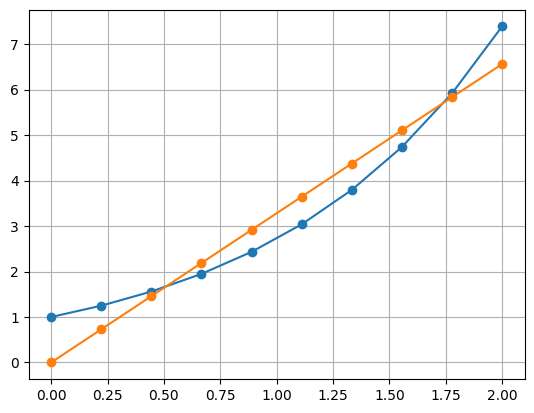

In [33]:
x = Dist(np.linspace(0, 2, 10))

plt.plot(x.m, x.expm, '-o')
plt.plot(x.m, x.ft, '-o')
plt.grid()

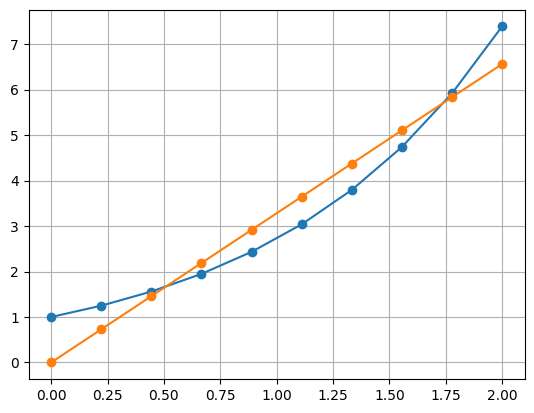

In [34]:
y = Dist.fromexpm(np.geomspace(1, np.exp(2), 10))

plt.plot(y.m, y.expm, '-o')
plt.plot(y.m, y.ft, '-o')
plt.grid()

The physical quantity creation methods follow the path described above: the contents of the json file are converted into a list of dicts; a dict is converted into a list of tuples; the list of tuples is converted into a graph of linear scalings; the physical quantity is created from the graph.